In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Fine Tuning Transformer for Summary Generation

In [ ]:
!pip install transformers -q
!pip install wandb -q

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import T5Tokenizer, T5ForConditionalGeneration

import wandb

In [ ]:
# Checking out the GPU we have access to
!nvidia-smi

Sat Apr 12 11:27:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P0             28W /   70W |    1056MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'


In [ ]:
# Login to wandb to log the model run and all the parameters
! wandb login

wandb: Currently logged in as: pranjalv (pranjalv-mit-world-peace-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Preparing the Dataset for data processing

In [ ]:
# Creating a custom dataset for reading the dataframe and loading it into the dataloader to pass it to the neural network at a later stage for finetuning the model and to prepare it for predictions

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.text
        self.ctext = self.data.ctext

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        ctext = str(self.ctext[index])
        ctext = ' '.join(ctext.split())

        text = str(self.text[index])
        text = ' '.join(text.split())

        source = self.tokenizer.batch_encode_plus([ctext], max_length= self.source_len, padding='max_length', truncation=True, return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([text], max_length= self.summ_len, padding='max_length', truncation=True, return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long),
            'source_mask': source_mask.to(dtype=torch.long),
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

## Fine Tuning the Model

In [ ]:
# Creating the training function. This will be called in the main function. It is run depending on the epoch value.
# The model is put into train mode and then we wnumerate over the training loader and passed to the defined network

def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        labels = y[:, 1:].clone().detach()
        labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=labels)
        loss = outputs[0]

        if _%10 == 0:
            wandb.log({"Training Loss": loss.item()})

        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


## Validating the Model Performance

In [ ]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask,
                max_length=150,
                num_beams=2,
                repetition_penalty=2.5,
                length_penalty=1.0,
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

## Main Function

In [ ]:
def main():
    # WandB – Initialize a new run
    wandb.init(project="t5")

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training
    config = wandb.config          # Initialize config
    config.TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
    config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
    config.TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
    config.VAL_EPOCHS = 1
    config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    config.SEED = 42               # random seed (default: 42)
    config.MAX_LEN = 512
    config.SUMMARY_LEN = 150

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(config.SEED) # pytorch random seed
    np.random.seed(config.SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    tokenizer = T5Tokenizer.from_pretrained("t5-base")


    # Importing and Pre-Processing the domain data
    # Selecting the needed columns only.
    # Adding the summarzie text in front of the text. This is to format the dataset similar to how T5 model was trained for summarization task.
    df = pd.read_csv('news_summary.csv',encoding='latin-1')
    df = df[['text','ctext']]
    df.ctext = 'summarize: ' + df.ctext
    print(df.head())


    # Creation of Dataset and Dataloader
    # Defining the train size. So 80% of the data will be used for training and the rest will be used for validation.
    train_size = 0.8
    train_dataset=df.sample(frac=train_size,random_state = config.SEED)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(val_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)



    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    model = model.to(device)

    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        final_df.to_csv('predictions.csv')
        print('Output Files generated for review')

if __name__ == '__main__':
    main()

                                                text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  
0  summarize: The Daman and Diu administration on...  
1  summarize: From her special numbers to TV?appe...  
2  summarize: The Indira Gandhi Institute of Medi...  
3  summarize: Lashkar-e-Taiba's Kashmir commander...  
4  summarize: Hotels in Mumbai and other Indian c...  
FULL Dataset: (4514, 2)
TRAIN Dataset: (3611, 2)
TEST Dataset: (903, 2)
Initiating Fine-Tuning for the model on our dataset


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch: 0, Loss:  7.057629108428955
Epoch: 0, Loss:  1.37886381149292
Epoch: 0, Loss:  1.3957101106643677
Epoch: 0, Loss:  1.3915761709213257
Epoch: 1, Loss:  2.794391632080078
Epoch: 1, Loss:  1.3062658309936523
Epoch: 1, Loss:  1.3792438507080078
Epoch: 1, Loss:  1.2469969987869263
Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe
Completed 0
Completed 100
Completed 200
Completed 300
Completed 400
Output Files generated for review


<a id='section06'></a>
### Examples of the Summary Generated from the model

##### Example 1

**Original Text**
New Delhi, Apr 25 (PTI) Union minister Vijay Goel today batted for the unification of the three municipal corporations in the national capital saying a discussion over the issue was pertinent. The BJP leader, who was confident of a good show by his party in the MCD polls, the results of which will be declared tomorrow, said the civic bodies needed to be "revamped" in order to deliver the services to the people more effectively. The first thing needed was a discussion on the unification of the three municipal corporations and there should also be an end to the practice of sending Delhi government officials to serve in the civic bodies, said the Union Minister of State (Independent Charge) for Youth Affairs and Sports. "Barring one, the two other civic bodies have been incurring losses. It would be more fruitful and efficient if all the three were merged," he said, referring to the north, south and east Delhi municipal corporations. The erstwhile Municipal Corporation of Delhi (MCD) was trifurcated into NDMC, SDMC and EDMC by the then Sheila Dikshit-led Delhi government in 2012. Goel predicted a "thumping" victory for the BJP in the MCD polls. He said the newly-elected BJP councillors will be trained on the functioning of the civic bodies and dealing with the bureaucracy.


**Original Summary**
Union Minister Vijay Goel has favoured unification of three MCDs ? North, South and East ? in order to deliver the services more effectively. "Barring one, the two other civic bodies have been incurring losses. It would be more fruitful and efficient if all the three were merged," he said. MCD was trifurcated into EDMC, NDMC and SDMC in 2012.

**Generated Summary**
BJP leader Vijay Goel on Saturday batted for the unification of three municipal corporations in the national capital saying a discussion over this was pertinent. "Barring one, two other civic bodies have been incurring losses," said Goels. The erstwhile Municipal Corporations of Delhi (MCD) were trifurcated into NDMC and SDMC by the then Sheilha Dikshi-led government in 2012. Notably, the MCD poll results will be declared tomorrow.

##### Example 2

**Original Text**
After much wait, the first UDAN flight took off from Shimla today after being flagged off by Prime Minister Narendra Modi.The flight will be operated by Alliance Air, the regional arm of Air India. PM Narendra Modi handed over boarding passes to some of passengers travelling via the first UDAN flight at the Shimla airport.Tomorrow PM @narendramodi will flag off the first UDAN flight under the Regional Connectivity Scheme, on Shimla-Delhi sector.Air India yesterday opened bookings for the first launch flight from Shimla to Delhi with all inclusive fares starting at Rs2,036.THE GREAT 'UDAN'The UDAN (Ude Desh ka Aam Naagrik) scheme seeks to make flying more affordable for the common people, holding a plan to connect over 45 unserved and under-served airports.Under UDAN, 50 per cent of the seats on each flight would have a cap of Rs 2,500 per seat/hour. The government has also extended subsidy in the form of viability gap funding to the operators flying on these routes.The scheme was launched to "make air travel accessible to citizens in regionally important cities," and has been described as "a first-of-its-kind scheme globally to stimulate regional connectivity through a market-based mechanism." Report have it the first flight today will not be flying at full capacity on its 70-seater ATR airplane because of payload restrictions related to the short Shimla airfield.|| Read more ||Udan scheme: Now you can fly to these 43 cities, see the full list hereUDAN scheme to fly hour-long flights capped at Rs 2,500 to smaller cities


**Original Summary**
PM Narendra Modi on Thursday launched Ude Desh ka Aam Nagrik (UDAN) scheme for regional flight connectivity by flagging off the inaugural flight from Shimla to Delhi. Under UDAN, government will connect small towns by air with 50% plane seats' fare capped at?2,500 for a one-hour journey of 500 kilometres. UDAN will connect over 45 unserved and under-served airports.

**Generated Summary**
UDAN (Ude Desh Ka Aam Naagrik) scheme, launched to make air travel accessible in regionally important cities under the Regional Connectivity Scheme, took off from Shimla on Tuesday. The first flight will be operated by Alliance Air, which is the regional arm of India's Air India. Under the scheme, 50% seats would have?2,500 per seat/hour and 50% of the seats would have capped at this rate. It was also extended subsidy in form-based funding for operators flying these routes as well.

##### Example 3

**Original Text**
New Delhi, Apr 25 (PTI) The Income Tax department has issued a Rs 24,646 crore tax demand notice to Sahara Groups Aamby Valley Limited (AVL) after conducting a special audit of the company. The department, as part of a special investigation and audit into the account books of AVL, found that an income of over Rs 48,000 crore for a particular assessment year was allegedly not reflected in the record books of the firm and hence it raised a fresh tax demand and penalty amount on it. A Sahara Group spokesperson confirmed the development to PTI. "Yes, the Income Tax Department has raised Rs 48,085.79 crores to the income of the Aamby Valley Limited with a total demand of income tax of Rs 24,646.96 crores on the Aamby Valley Limited," the spokesperson said in a brief statement. Officials said the notice was issued by the taxman in January this year after the special audit of AVLs income for the Assessment Year 2012-13 found that the parent firm had allegedly floated a clutch of Special Purpose Vehicles whose incomes were later accounted on the account of AVL as they were merged with the former in due course of time. The AVL, in its income return filed for AY 2012-13, had reflected a loss of few crores but the special I-T audit brought up the added income, a senior official said. The Supreme Court, last week, had asked the Bombay High Courts official liquidator to sell the Rs 34,000 crore worth of properties of Aamby Valley owned by the Sahara Group and directed its chief Subrata Roy to personally appear before it on April 28.  


**Original Summary**
The Income Tax Department has issued a ?24,646 crore tax demand notice to Sahara Group's Aamby Valley Limited. The department's audit found that an income of over ?48,000 crore for the assessment year 2012-13 was not reflected in the record books of the firm. A week ago, the SC ordered Bombay HC to auction Sahara's Aamby Valley worth ?34,000 crore.

**Generated Summary**
the Income Tax department has issued a?24,646 crore tax demand notice to Sahara Groups Aamby Valley Limited (AVL) after conducting an audit of the company. The notice was issued in January this year after the special audit found that the parent firm had floated Special Purpose Vehicle income for the Assessment Year 2012-13 and later accounted on its account as they were merged with the former. "Yes...the Income Tax Department raised Rs48,085.79 crores to the income," he added earlier said at the notice.

## Qualitative Analysis (e.g., side-by-side comparisons)

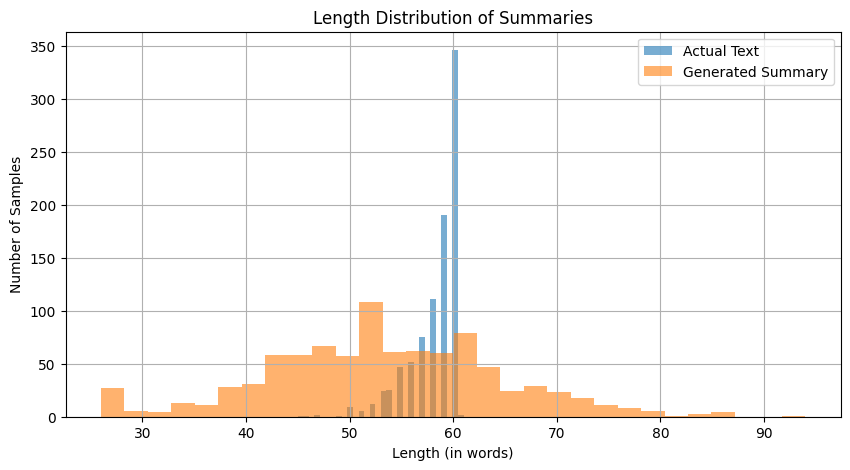

In [ ]:
#Shows how consistent or verbose your model is compared to the original summaries

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('predictions.csv')

df['act_len'] = df['Actual Text'].str.split().apply(len)
df['gen_len'] = df['Generated Text'].str.split().apply(len)

plt.figure(figsize=(10, 5))
plt.hist(df['act_len'], bins=30, alpha=0.6, label='Actual Text')
plt.hist(df['gen_len'], bins=30, alpha=0.6, label='Generated Summary')
plt.xlabel("Length (in words)")
plt.ylabel("Number of Samples")
plt.title("Length Distribution of Summaries")
plt.legend()
plt.grid(True)
plt.show()


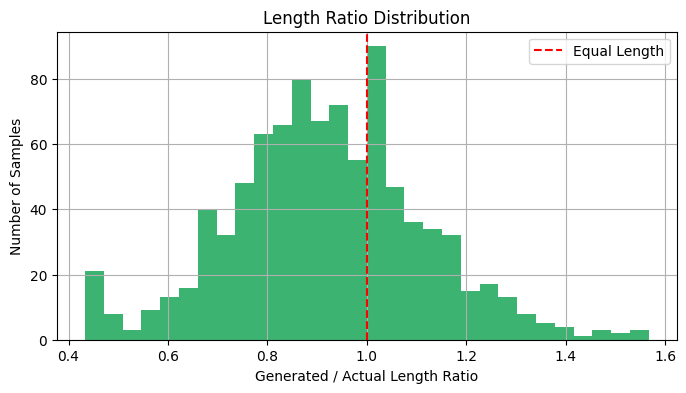

In [ ]:
#To quantitatively show how concise the model's output is compared to the input

df['len_ratio'] = df['gen_len'] / df['act_len']

plt.figure(figsize=(8, 4))
plt.hist(df['len_ratio'], bins=30, color='mediumseagreen')
plt.axvline(1.0, color='red', linestyle='--', label='Equal Length')
plt.xlabel("Generated / Actual Length Ratio")
plt.ylabel("Number of Samples")
plt.title("Length Ratio Distribution")
plt.legend()
plt.grid(True)
plt.show()


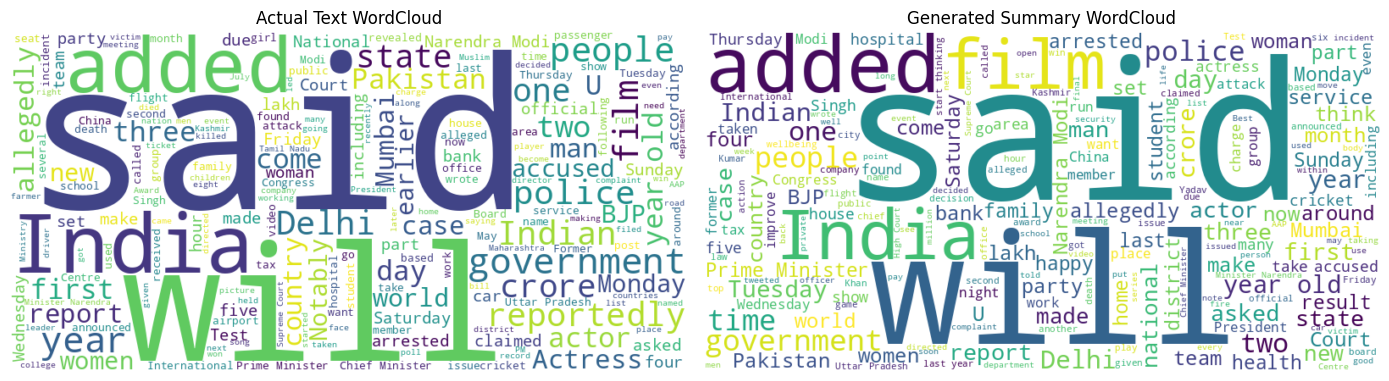

In [ ]:
#Quickly shows what kind of words dominate input vs. generated summaries

from wordcloud import WordCloud

actual_words = ' '.join(df['Actual Text'])
generated_words = ' '.join(df['Generated Text'])

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title("Actual Text WordCloud")
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(actual_words), interpolation='bilinear')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Generated Summary WordCloud")
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(generated_words), interpolation='bilinear')
plt.axis('off')

plt.tight_layout()
plt.show()


## Quantitative Metrics (e.g., ROUGE)

In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=7f54714bc5678c380d6b19162ad052cb2b7685fa19be4dfbc1186cb688435b92
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
import pandas as pd
from rouge_score import rouge_scorer
from tqdm import tqdm

# Load predictions
df = pd.read_csv('predictions.csv')

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Compute ROUGE scores
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

for i in tqdm(range(len(df))):
    reference = str(df.loc[i, 'Actual Text'])
    prediction = str(df.loc[i, 'Generated Text'])
    scores = scorer.score(reference, prediction)

    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Add to dataframe
df['ROUGE-1'] = rouge1_scores
df['ROUGE-2'] = rouge2_scores
df['ROUGE-L'] = rougeL_scores

# Print average scores
print("\nAverage ROUGE-1:", round(df['ROUGE-1'].mean(), 4))
print("Average ROUGE-2:", round(df['ROUGE-2'].mean(), 4))
print("Average ROUGE-L:", round(df['ROUGE-L'].mean(), 4))


100%|██████████| 903/903 [00:02<00:00, 389.19it/s]


Average ROUGE-1: 0.4827
Average ROUGE-2: 0.2641
Average ROUGE-L: 0.364


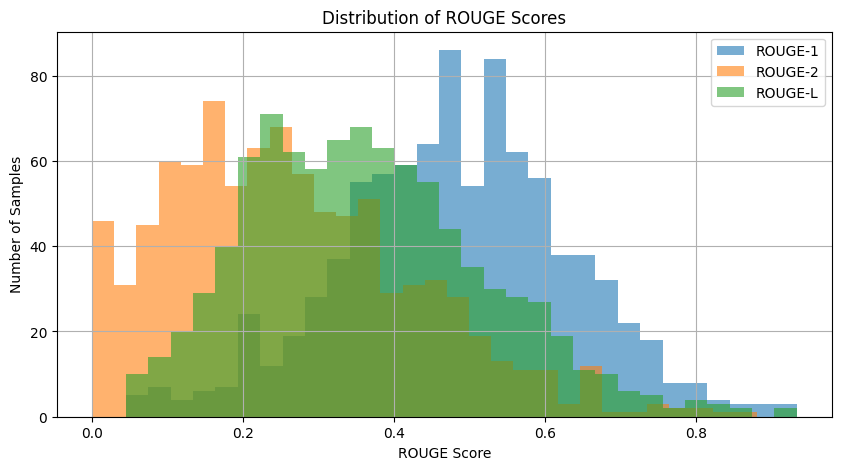

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['ROUGE-1'], bins=30, alpha=0.6, label='ROUGE-1')
plt.hist(df['ROUGE-2'], bins=30, alpha=0.6, label='ROUGE-2')
plt.hist(df['ROUGE-L'], bins=30, alpha=0.6, label='ROUGE-L')
plt.xlabel("ROUGE Score")
plt.ylabel("Number of Samples")
plt.title("Distribution of ROUGE Scores")
plt.legend()
plt.grid(True)
plt.show()
